## fastq viewer

* https://biopython.org/DIST/docs/api/Bio.SeqIO.QualityIO-module.html
* https://www.bioinformatics.babraham.ac.uk/projects/fastqc/

In [102]:
import os, sys, io, random, subprocess, time
import string
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
from importlib import reload

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO
from pyfaidx import Fasta

from IPython.display import HTML

from bokeh.plotting import figure
from bokeh.models import (ColumnDataSource, Plot, LinearAxis, Grid, Range1d,CustomJS, Slider,
                          HoverTool, NumeralTickFormatter, Label, Range1d, Band)
from bokeh.models.glyphs import Text, Rect, Line
from bokeh.layouts import gridplot, column
import panel as pn
import panel.widgets as pnw
pn.extension()

from pybioviz import dashboards, plotters, utils

## fastq quality plot

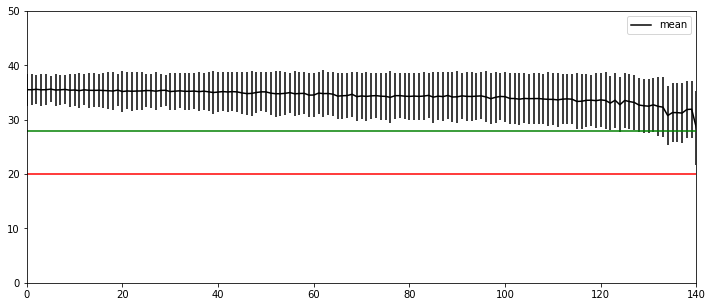

In [115]:
def fastq_to_dataframe(filename, n=10):
    i=0
    data=[]
    for record in SeqIO.parse(filename, "fastq"):
        print("%s %s" % (record.id, record.seq))
        q = record.letter_annotations["phred_quality"]
        print (q)
        i+=1
        if i>n:
            break
    return

def fastq_to_quals(filename,n=10):
    i=0
    data=[]
    for record in SeqIO.parse(filename, "fastq"):
        q = record.letter_annotations["phred_quality"]
        data.append(q)
        i+=1
        if i>n:
            break
    return data

#d=fastq_to_quals('SRR1980728.fastq',n=200)
d = fastq_to_quals('test.fastq',n=5000)
df = pd.DataFrame(d)
import pylab as plt
x = df.describe().T
x['x'] = x.index+1
#print (x)

ax=x.plot(y='mean',yerr='std',figsize=(12,5),c='black',ylim=(0,50))
ax.axhline(20,c='r')
ax.axhline(28,c='g')

In [116]:
def plot_quals(df):
    
    df['lower'] = df['mean']-df['std']/2
    df['upper'] = df['mean']+df['std']/2
    source = ColumnDataSource(df)
    p = figure(plot_width=800,plot_height=400,y_range=(0,50))
    l = Line(x='x',y='mean',line_width=2)
    band = Band(base='x', lower='lower', upper='upper', level='underlay', source=source,
                fill_alpha=1.0, line_width=1, line_color='black')
    p.add_glyph(source, l)  
    p.add_layout(band)
    r=Rect()
    return p

pn.pane.Bokeh(plot_quals(x))

Bokeh(Figure)

## faster reader?

In [54]:
#https://github.com/lh3/readfq/blob/master/readfq.py

def readfq(fp): # this is a generator function
    last = None # this is a buffer keeping the last unprocessed line
    while True: # mimic closure; is it a bad idea?
        if not last: # the first record or a record following a fastq
            for l in fp: # search for the start of the next record
                if l[0] in '>@': # fasta/q header line
                    last = l[:-1] # save this line
                    break
        if not last: break
        name, seqs, last = last[1:].partition(" ")[0], [], None
        for l in fp: # read the sequence
            if l[0] in '@+>':
                last = l[:-1]
                break
            seqs.append(l[:-1])
        if not last or last[0] != '+': # this is a fasta record
            yield name, ''.join(seqs), None # yield a fasta record
            if not last: break
        else: # this is a fastq record
            seq, leng, seqs = ''.join(seqs), 0, []
            for l in fp: # read the quality
                seqs.append(l[:-1])
                leng += len(l) - 1
                if leng >= len(seq): # have read enough quality
                    last = None
                    yield name, seq, ''.join(seqs); # yield a fastq record
                    break
            if last: # reach EOF before reading enough quality
                yield name, seq, None # yield a fasta record instead
                break
st=time.time()
file=open('SRR1980728.fastq','r')
for name, seq, qual in readfq(file):   
    s=seq
t=time.time()-st
print (t)

0.011542081832885742
